# Logistic growth

In this example, we are going to perform inference for the logistic growth model commonly used in population biology to describe resource-limited growth. The population density of a given bacteria is supposed to follow:

\begin{equation}
\frac{d y}{d t} = r y (1 - \frac{y}{k})
\end{equation}

where we assume $y(0)>0$; $r > 0$ is the initial (exponential) growth rate when resources are abundant; $\kappa > 0$ is the carrying capacity denoting the steady-state population density.

## 1. 
Using Scipy's integrator, write a function which numerically solves the logistic equation. Plot the solution for $y(0)=5, r=0.2, \kappa=20$ from $t=0$ to $t=40$.

In [1]:
import numpy as np
from scipy.integrate import odeint
from plotnine import *
import pandas as pd

def logistic_rhs(y, t, r, k):
    return r * y * (1 - y / k)

def logistic_solve(times, r, k, y0):
    sol = odeint(logistic_rhs, [y0], times, args=(r, k))
    df = pd.DataFrame({'t': times, 'y': sol[:, 0]})
    return df

df = logistic_solve(np.linspace(0, 40, 100), 0.2, 20, 5)
(ggplot(df, aes(x='t', y='y')) +
 geom_line())

<Figure size 640x480 with 1 Axes>

<ggplot: (337131065)>

## 2.
Assume that the observed data differs from the logistic model solution according to the measurement equation:

\begin{equation}
\tilde y(t) \sim \mathcal{N}(y(t), \sigma),
\end{equation}

where $\sigma >0$ controls the measurement variability. Generate 'observed' data at $t= 0, 5, 10, 15, 20, 25, 30, 35, 40$ assuming $y(0)=5, r=0.2, \kappa=20, \sigma=2$. Plot these data overlaid on top of the true solution.

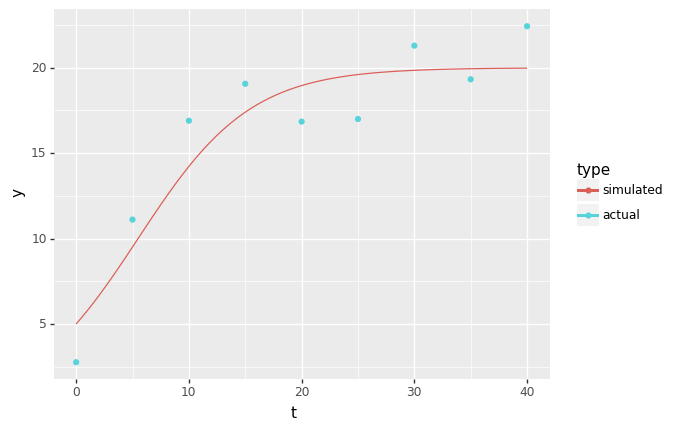

<ggplot: (339311473)>

In [2]:
times = np.arange(0, 45, 5)
df_short = logistic_solve(times, 0.2, 20, 5)
def logistic_observations(y, sigma):
    return np.random.normal(y, sigma, len(y))

df_short['y'] = logistic_observations(df_short['y'], 2)
df_short['type'] = 'actual'
df['type'] = 'simulated'
df_both = pd.concat([df, df_short])


(ggplot(df_both[df_both['type']=='simulated'], aes(x='t', y='y', colour='type')) +
 geom_line() +
 geom_point(df_both[df_both['type']=='actual']))

## 3.
The likelihood for this model is given by:

\begin{equation}
L = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \exp(-\frac{(\tilde y(t_i) - y(t_i))^2}{2\sigma^2})
\end{equation}

where $N$ is the number of observations and $y(t) = y(t|r,\kappa, y(0))$ is the ODE solution at time $t$. Write a function which calculates the log-likelihood for given $(r, \kappa, y(0), \sigma)$.

In [3]:
import scipy.stats

def logistic_log_likelihood(times, y_tilde, r, k, y0, sigma):
    df = logistic_solve(times, r, k, y0)
    log_p = 0.0
    for i in range(len(times)):
        log_p += scipy.stats.norm.logpdf(y_tilde[i], df['y'][i], sigma)
    return log_p

## 4.
Using the simulated data you previously generated, plot the log-likelihood as a function of $r$ holding all other parameters at their true values.

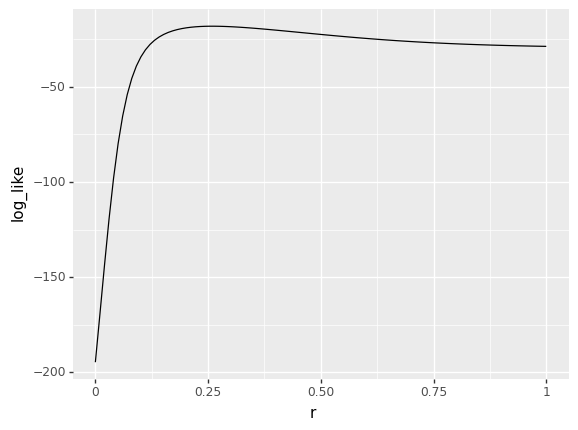

<ggplot: (337144137)>

In [4]:
r = np.linspace(0, 1, 100)
log_like = np.zeros(len(r))
for i in range(len(r)):
    log_like[i] = logistic_log_likelihood(times, df_short['y'], r[i], 20, 5, 2)

df_log_like = pd.DataFrame({'r': r, 'log_like': log_like})
(ggplot(df_log_like, aes(x='r', y='log_like')) +
 geom_line())

## 5.
Plot the likelihood (not the log-likelihood as this is harder to distinguish) contour surface for $(r,k)$ holding all other parameters at their true values.

/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.


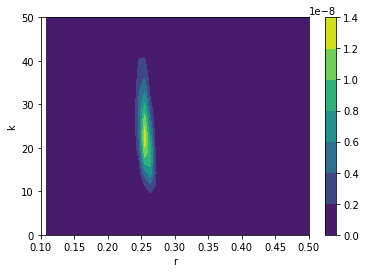

In [5]:
import matplotlib.pyplot as plt
r = np.linspace(0.1, 0.5, 50)
k = np.linspace(0, 50, 50)
X, Y = np.meshgrid(r, k)
Z = np.zeros((len(r), len(k)))
for i in range(len(r)):
    for j in range(len(k)):
        Z[i, j] = logistic_log_likelihood(times, df_short['y'], r[i], k[j], 5, 2)

fig,ax=plt.subplots(1, 1)
cp = ax.contourf(X, Y, np.exp(Z))
fig.colorbar(cp)
ax.set_xlabel('r')
ax.set_ylabel('k')
plt.show()

## 6.

Assume we have priors on parameters: $r\sim \mathcal{N}(0.2, 0.02), \kappa\sim \mathcal{N}(20, 4)$, and we fix $y(0)=5$. Generate 100 prior predictive simulations of the ODE solution $y$ and plot these. Remember, a single prior predictive simulation is obtained by sampling each parameter from its prior and (in this case) solving the ODE for this parameter set.

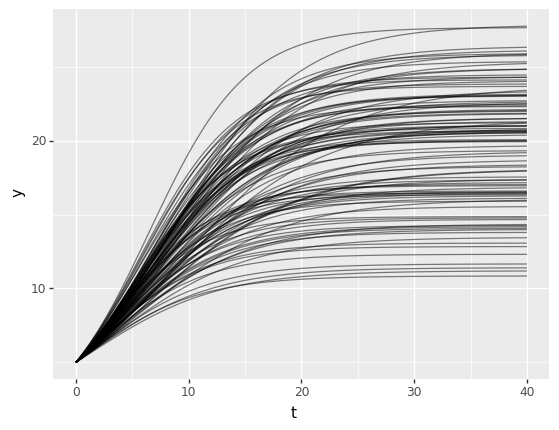

<ggplot: (341739537)>

In [6]:
n = 100
for i in range(n):
    r = np.random.normal(0.2, 0.02, 1)
    k = np.random.normal(20, 4, 1)
    temp = logistic_solve(np.linspace(0, 40, 100), r, k, 5)
    temp['simulation'] = str(i)
    if i == 0:
        df_big = temp
    else:
        df_big = pd.concat([df_big, temp])

(ggplot(df_big, aes(x='t', y='y', group='simulation')) +
 geom_line(alpha=0.5))

## 7.
Now also allow $y(0)\sim \mathcal{N}(5, 1)$. How does the prior predictive distribution change? 

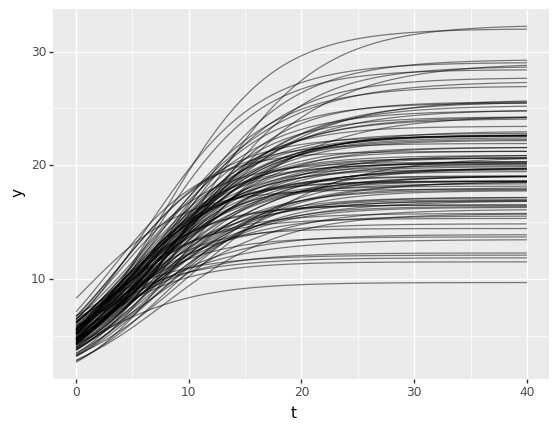

<ggplot: (341800469)>

In [7]:
for i in range(n):
    r = np.random.normal(0.2, 0.02, 1)[0]
    k = np.random.normal(20, 4, 1)[0]
    y0 = np.random.normal(5, 1, 1)[0]
    temp = logistic_solve(np.linspace(0, 40, 100), r, k, y0)
    temp['simulation'] = str(i)
    if i == 0:
        df_big = temp
    else:
        df_big = pd.concat([df_big, temp])

(ggplot(df_big, aes(x='t', y='y', group='simulation')) +
 geom_line(alpha=0.5))

## 8.
We are now going to write a random walk Metropolis sampler. The first step is to write a method which takes as input $(r,\kappa, \sigma)$ and proposes new values using univariate normal distributions centered at the current values. So, for example,

\begin{equation}
r'\sim\mathcal{N}(r,\tau_r)
\end{equation}

where $\tau_r$ is a hyperparameter of the method. Write such a function.

In [8]:
def propose(r, k, sigma, tau_r, tau_k, tau_sigma):
    r = np.random.normal(r, tau_r)
    k = np.random.normal(k, tau_k)
    sigma = np.random.normal(sigma, tau_sigma)
    return r, k, sigma

## 9.
Assume priors: $r\sim \mathcal{N}(0.2, 0.02), \kappa\sim \mathcal{N}(20, 4), \sigma \sim \mathcal{N}(2, 0.2)$ and fix $y(0)=5$. Write a function that accepts as input $(r,\kappa, \sigma)$ and outputs the log-prior density $\log{\text -}p(r,\kappa, \sigma)$.

In [9]:
def prior(r, k, sigma):
    lp = (scipy.stats.norm.logpdf(r, 0.2, 0.02) +
          scipy.stats.norm.logpdf(k, 20, 4) +
          scipy.stats.norm.logpdf(sigma, 2, 0.2))
    return lp

## 10.
 Write a function which calculates the unnormalised log-posterior (i.e. the sum of the log-prior and log-likelihood), $\text{log-}p(r,\kappa,\sigma|\text{data})$, for a given parameter set.

In [10]:
def posterior(r, k, sigma, y0, times, y_tilde):
    ll = logistic_log_likelihood(times, y_tilde, r, k, y0, sigma)
    lp = prior(r, k, sigma)
    return ll + lp

In [11]:
posterior(0.4, 20, 2, 5, times, df_short['y'])

-68.93407322977154

## 11.
The next step is to write a function called 'step_accept' which takes as input $(r,\kappa, \sigma)$, proposes new values $(r',\kappa', \sigma')$. Then calculates the ratio:

\begin{equation}
t = \exp(\text{log-}p(r',\kappa', \sigma'|\text{data}) - \text{log-}p(r,\kappa, \sigma|\text{data}))
\end{equation}

Then generates $u\sim U(0,1)$ and does the following: if $t \geq u$, return $(r',\kappa',\sigma')$; else return $(r,\kappa,\sigma)$.

In [12]:
def step_accept(r, k, sigma, y0, times, y_tilde, tau_r, tau_k, tau_sigma):
    r_prime, k_prime, sigma_prime = propose(r, k, sigma, tau_r, tau_k, tau_sigma)
    logp_current = posterior(r, k, sigma, y0, times, y_tilde)
    logp_proposed = posterior(r_prime, k_prime, sigma_prime, y0, times, y_tilde)
    t = np.exp(logp_proposed - logp_current)
    u = np.random.uniform()
    if t >= u:
        return r_prime, k_prime, sigma_prime
    else:
        return r, k, sigma

In [13]:
step_accept(0.2, 18, 1.5, 5, times, df_short['y'], 0.01, 1, 0.1)

(0.2, 18, 1.5)

## 12.
Write a function which iterates 'step_accept' generating a chain of MCMC samples of $(r,\kappa,\sigma)$. Initialise $(r,\kappa,\sigma)$ using samples from the prior.

In [14]:
def MCMC(numsamples, r, k, sigma, y0, times, y_tilde, tau_r, tau_k, tau_sigma):
    r = np.random.normal(0.2, 0.02)
    k = np.random.normal(20, 4)
    sigma = np.random.normal(2, 0.2)
    m_samples = np.zeros((numsamples, 3))
    m_samples[0, :] = [r, k, sigma]
    for i in range(1, numsamples):
        r, k, sigma = step_accept(r, k, sigma, y0, times, y_tilde, tau_r, tau_k, tau_sigma)
        m_samples[i, :] = [r, k, sigma]
    df = pd.DataFrame({'r': m_samples[:, 0], 'k': m_samples[:, 1],
                       'sigma': m_samples[:, 2], 'iter': np.arange(0, numsamples)})
    return df

## 13.
Assuming step sizes of $(\tau_r=0.01,\tau_k=1, \tau_{\sigma}=0.1)$, generate an MCMC sample of 1000 draws. Visualise the sampled values of $r$ over time.

In [15]:
df = MCMC(1000, 0.2, 18, 1.5, 5, times, df_short['y'], 0.01, 1, 0.1)

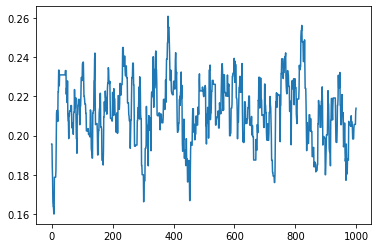

In [16]:
plt.plot(df['r'])
plt.show()

## 14.
Plot the pairwise distribution of $(r,\kappa)$. How do the sampled values compare to the true parameters?

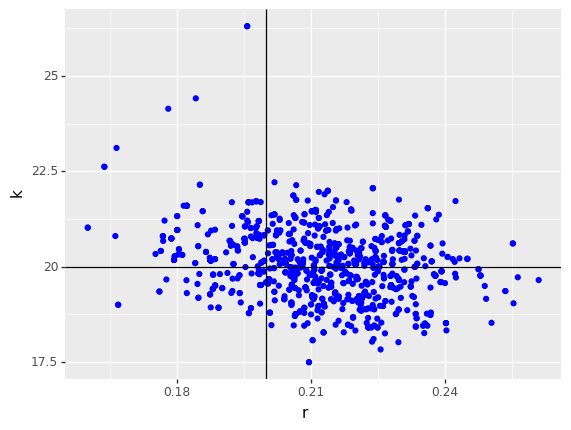

<ggplot: (342251269)>

In [17]:
(ggplot(df, aes(x='r', y='k')) +
 geom_point(colour='blue') +
 geom_vline(xintercept=0.2) +
 geom_hline(yintercept=20))

## 15.
Modify your MCMC routine to use the following half-normal distributions to sample initial points for your chains. Run four independent chains for 1000 iterations each and plot the $\kappa$ samples over time. How long does it appear your chains be run until they reach a stationary distribution?

$r \sim \text{half-N}(0.2, 0.1)$
$\kappa \sim \text{half-N}(0, 20, 10)$
$\sigma \sim \text{half-N}(2, 1)$

Note, to do so, you can use the following function:

<code>
def truncated_normal(mu, sd):
    myclip_a = 0
    myclip_b = 1000000
    my_mean = mu
    my_std = sd

    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    r = scipy.stats.truncnorm.rvs(a, b, loc=my_mean, scale=my_std, size=1)
    return r[0]
</code>

In [99]:
def truncated_normal(mu, sd):
    myclip_a = 0
    myclip_b = 1000000
    my_mean = mu
    my_std = sd

    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    r = scipy.stats.truncnorm.rvs(a, b, loc=my_mean, scale=my_std, size=1)
    return r[0]

In [97]:
def MCMC(numsamples, r, k, sigma, y0, times, y_tilde, tau_r, tau_k, tau_sigma):
    r = truncated_normal(0, 0.2, 0.1)
    k = truncated_normal(0, 20, 10)
    sigma = truncated_normal(0, 2, 1)
    m_samples = np.zeros((numsamples, 3))
    m_samples[0, :] = [r, k, sigma]
    for i in range(1, numsamples):
        r, k, sigma = step_accept(r, k, sigma, y0, times, y_tilde, tau_r, tau_k, tau_sigma)
        m_samples[i, :] = [r, k, sigma]
    df = pd.DataFrame({'r': m_samples[:, 0], 'k': m_samples[:, 1],
                       'sigma': m_samples[:, 2], 'iter': np.arange(0, numsamples)})
    return df

df = MCMC(1000, 0.2, 18, 1.5, 5, times, df_short['y'], 0.01, 1, 0.1)
df['chain'] = '1'
df1 = MCMC(1000, 0.2, 18, 1.5, 5, times, df_short['y'], 0.01, 1, 0.1)
df1['chain'] = '2'
df2 = MCMC(1000, 0.2, 18, 1.5, 5, times, df_short['y'], 0.01, 1, 0.1)
df2['chain'] = '3'
df3 = MCMC(1000, 0.2, 18, 1.5, 5, times, df_short['y'], 0.01, 1, 0.1)
df3['chain'] = '4'

df_all = pd.concat([df, df1, df2, df3])

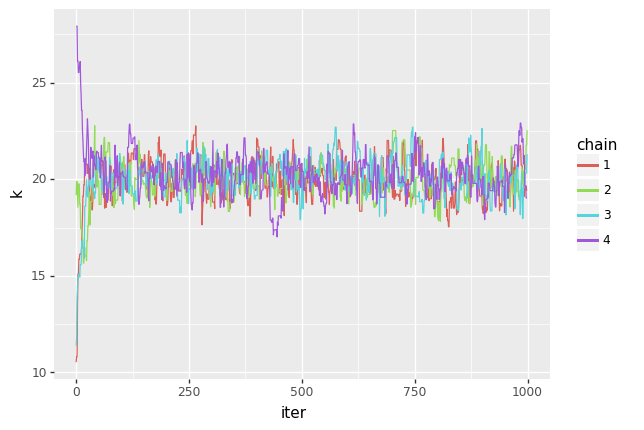

<ggplot: (342165129)>

In [98]:
(ggplot(df_all, aes(x='iter', y='k', colour='chain')) +
 geom_line())

## 16.
Using a random subset of 100 samples from all four chains taken from after they appear to have reached the stationary distribution, draw from the posterior predictive distribution of the logistic equation solution and overlay the observations.

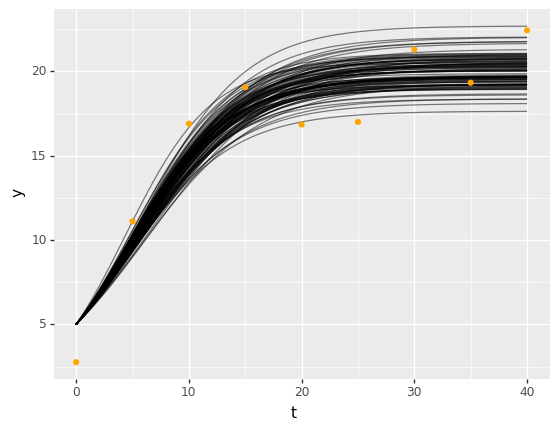

<ggplot: (347988221)>

In [120]:
df_all_after = df_all.query('iter > 250')
nsamples = 100
idx = np.random.randint(len(df_all_after), size=nsamples)
df_all_after = df_all_after.sample(n=nsamples)

for i in range(nsamples):
    r = df_all_after['r'].iloc[i]
    k = df_all_after['k'].iloc[i]
    temp = logistic_solve(np.linspace(0, 40, 100), r, k, 5)
    temp['simulation'] = str(i)
    if i == 0:
        df_big = temp
    else:
        df_big = pd.concat([df_big, temp])

        
df_big['type'] = 'simulation'
df_short
df_todo = pd.concat([df_big, df_short])
(ggplot(df_todo.query('type == "simulation"'), aes(x='t', y='y', group='simulation')) +
 geom_line(alpha=0.5) +
 geom_point(df_todo.query('type != "simulation"'), colour="orange"))

# Lotka-Volterra

In this practical, we are going to perform inference for the Lotka-Volterra model of population dynamics. The model describes the dynamics of population sizes of prey ($u(t)$) and predators ($v(t)$), where, here, $t$ denotes a given time in years. These equations are given by:

\begin{align}
\frac{d u}{dt} &= \alpha u - \beta u v\\
\frac{d v}{dt} &= -\gamma v + \delta u v
\end{align}

where at time $t=0$, $u(0) = u_0$ and $v(0)=v_0$. Here, $\alpha\geq 0$ yields the prey population growth rate in the absence of predators; $\beta \geq 0$ is the rate of decline in the prey as a result of predation; $\gamma \geq 0$ denotes the rate of decline of predators in absence of prey; $\delta > 0$ is the rate of predator population growth due to predation.

## Preliminary question!

Have you got PINTS installed on your machine? If not, clone the PINTS repo on: https://github.com/pints-team/pints and install it by executing:

`pip install -e .[dev,docs]`

on the terminal in the PINTS main directory. (If you want to avoid clashes with any local installed packages, you may want to use a virtual environment.)

## 1.
Write a function which solves these two equations for any choice of $(\alpha, \beta, \gamma, \delta, u_0, v_0)$. Plot the solutions for $\alpha=0.55, \beta=0.028, \gamma=0.84, \delta=0.026, u_0=33, v_0=6$.

Code up the RHS of equations and use numerical solver.

In [185]:
import numpy as np

def lotka_volterra_rhs(y, t, alpha, beta, gamma, delta):
    u, v = y
    dydt = [alpha * u - beta * u * v, -gamma * v + delta * u * v]
    return dydt

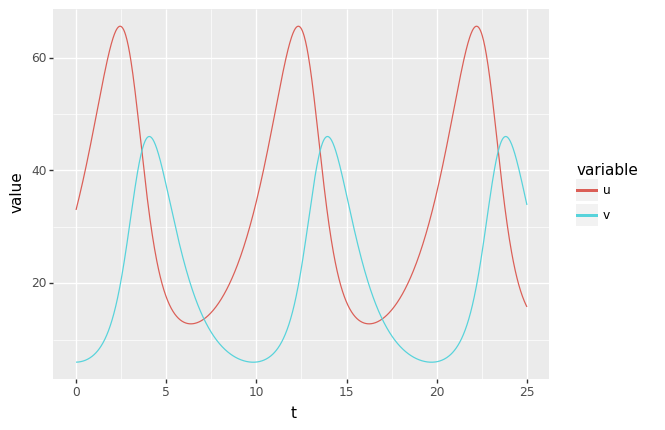

<ggplot: (349357413)>

In [186]:
from scipy.integrate import odeint
from plotnine import *
import pandas as pd

def lotka_volterra_solve(times, alpha, beta, gamma, delta, u_0, v_0):
    sol = odeint(lotka_volterra_rhs, [u_0, v_0], times, args=(alpha, beta, gamma, delta))
    df = pd.DataFrame({'t': times, 'u': sol[:, 0], 'v': sol[:, 1]})
    return df

times = np.linspace(0, 25, 1001)

df = lotka_volterra_solve(times, 0.55, 0.028, 0.84, 0.026, 33, 6)
df_long = pd.melt(df, id_vars='t')

(ggplot(df_long, aes(x='t', y='value', colour='variable')) +
 geom_line())

An alternative way to view this is as orbits.

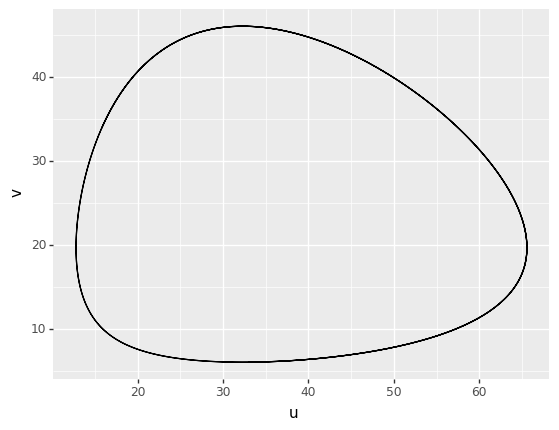

<ggplot: (348579965)>

In [187]:
(ggplot(df, aes(x='u', y='v')) +
 geom_path())

## 2.
Run the model with $\alpha=0.79, \beta=0.04, \gamma=1.3, \delta=0.04, u_0=33, v_0=6$. How do the dynamics compare with previous?

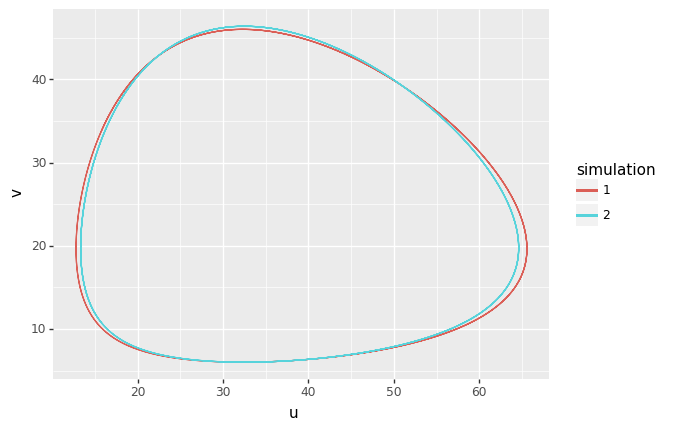

<ggplot: (348563081)>

In [188]:
df1 = lotka_volterra_solve(times, 0.79, 0.04, 1.3, 0.04, 33, 6)
df1['simulation'] = '2'
df['simulation'] = '1'
df_both = pd.concat([df, df1])

(ggplot(df_both, aes(x='u', y='v', colour='simulation')) +
 geom_path())

## 3.
Suppose that the observations for each population are governed by the following:

\begin{align}
\tilde u &= u \exp(\epsilon_u)\\
\tilde v &= v \exp(\epsilon_v)
\end{align}

where $\epsilon_u\sim\mathcal{N}(0, \sigma_u)$ and $\epsilon_v\sim\mathcal{N}(0, \sigma_v)$. Show that these are equivalent to:

\begin{align}
\tilde u &\sim \text{log-normal}(\log u, \sigma_u)\\
\tilde v &\sim \text{log-normal}(\log v, \sigma_v)\\
\end{align}

## 4.
Using these observation models, generate annual data for 25 years assuming $\sigma_u=\sigma_v=0.25$ and using the parameter sets from parts 1 and 2. Graph these observations.

Note, this may be a helpful resource: https://ben18785.shinyapps.io/distribution-zoo/

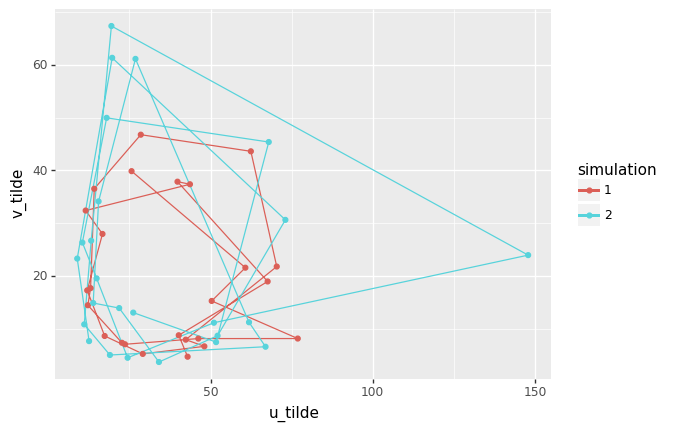

<ggplot: (345205373)>

In [189]:
def observations(df, sigma_u, sigma_v):
    u_tilde = np.zeros(len(df))
    v_tilde = np.zeros(len(df))
    for i in range(len(u_tilde)):
        u_tilde[i] = scipy.stats.lognorm.rvs(scale=df['u'][i], s=sigma_u, size=1)
        v_tilde[i] = scipy.stats.lognorm.rvs(scale=df['v'][i], s=sigma_v, size=1)
    df['u_tilde'] = u_tilde
    df['v_tilde'] = v_tilde
    return df

times = np.arange(0, 25, 1)
df = lotka_volterra_solve(times, 0.55, 0.028, 0.84, 0.026, 33, 6)
df = observations(df, 0.25, 0.25)
df['simulation'] = '1'
df1 = lotka_volterra_solve(times, 0.9, 0.04, 1.3, 0.04, 33, 6)
df1 = observations(df1, 0.25, 0.25)
df1['simulation'] = '2'

df_both = pd.concat([df, df1])

(ggplot(df_both, aes(x='u_tilde', y='v_tilde', colour='simulation')) +
 geom_path() +
 geom_point())

## 5.
The likelihood for the prey compartment is given by:

\begin{equation}
L_u = \prod_{t=1}^{T} \text{log-normal}(\tilde u(t)| \log u(t|\alpha, \beta, \gamma, \delta, u_0, v_0), \sigma_u)
\end{equation}

with a similar expression for the predator compartment. Here $u(t|\alpha, \beta, \gamma, \delta, u_0, v_0)$ is the solution of the Lotka-Volterra eqns. Write a function which calculates the log-likelihood of a set of observations with given values of $(\alpha, \beta, \gamma, \delta, u_0, v_0, \sigma_u, \sigma_v)$.

In [190]:
def lotka_volterra_u_loglikelihood(df_obs, alpha, beta, gamma, delta, u_0, v_0, sigma_u, sigma_v): 
    df = lotka_volterra_solve(df_obs['t'], alpha, beta, gamma, delta, u_0, v_0)
    log_p = 0.0
    for i in range(len(df_obs['t'])):
        log_p += scipy.stats.lognorm.logpdf(df_obs['u_tilde'][i], scale=df['u'][i], s=sigma_u)
        log_p += scipy.stats.lognorm.logpdf(df_obs['v_tilde'][i], scale=df['v'][i], s=sigma_v)
    return log_p

## 6.
Using the first of the series generated in question 4, plot a 1D slice through the log-likelihood surface for $\alpha$ whilst holding the other parameters $\beta=0.028, \gamma=0.84, \delta=0.026, u_0=33, v_0=6, \sigma_u=0.25, \sigma_v=0.25$. In this slice, how close is $\alpha$ to its true value?

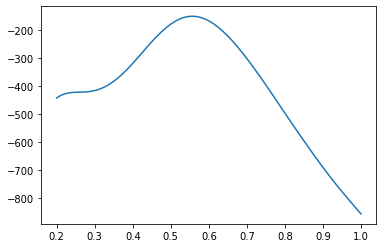

In [191]:
import matplotlib.pyplot as plt
alpha = np.linspace(0.2, 1, 100)
log_like = np.zeros(len(alpha))
for i in range(len(alpha)):
    log_like[i] = lotka_volterra_u_loglikelihood(df, alpha[i], 0.028, 0.84, 0.026, 33, 6, 0.25, 0.25)
plt.plot(alpha, log_like)
plt.show()

## 7.
PINTS is a Python package designed in the Department of Computer Science that provides access to all sorts of inference routines, which is especially good for ODEs. Following the approach given here: https://github.com/pints-team/pints/blob/master/examples/stats/custom-model.ipynb wrap wrap a pints.LogPDF class around the log-likelihood function we just created to allow us to access these methods. We're going to hold a number of parameters constant to make inference a little more manageable for this practical, so set up your method with $(u_0=33, v_0=6, \sigma_u=0.25, \sigma_v=0.25)$.

In [192]:
import pints

class LotkaVolterraLogPDF(pints.LogPDF):
    def __init__(self, df_obs, u0=33, v0=6, sigma_u=0.25, sigma_v=0.25):
        self._df_obs = df_obs
        self._u0 = u0
        self._v0 = v0
        self._sigma_u = sigma_u
        self._sigma_v = sigma_v

    def __call__(self, x):
        df_obs = self._df_obs
        u0 = self._u0
        v0 = self._v0
        sigma_u = self._sigma_u
        sigma_v = self._sigma_v
        return lotka_volterra_u_loglikelihood(df_obs, x[0], x[1], x[2], x[3],
                                              u0, v0, sigma_u, sigma_v)

    def n_parameters(self):
        return 4

## 8.
We now are going to use an inbuilt MCMC method in PINTS called `HaarioBardenetACMC` to generate posterior samples with 2000 iterations per chain and 200 initial phase iterations across 4 chains. To initialise each of the chains assume:

$(\alpha=0.6, \beta=0.02, \gamma=1.0, \delta=0.03)$

which can be done using:

`nchains = 4
xs = [[0.6, 0.02, 1.0, 0.03]] * nchains`

Note, initialising chains all at a single point is not good practive but allows us to get up and running faster.

To run the MCMC, we first instantiate the pints.LogPDF object you created in the previous question assuming observational data generated in question 4. Then we instantiate an MCMC Controller object using:

`mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)`

where `model` is an instantiated version of your model. Then we set the total number of iterations per chain and the initial phase iterations using:

`mcmc.set_max_iterations(2000)
mcmc.set_initial_phase_iterations(200)`

Finally, we execute:

`chains = mcmc.run()`

to run the MCMC.

Note that, at the moment, since we have not specified priors, PINTS implicitly assumes that the priors are uniform (and, in this case, improper).

In [135]:
model = LotkaVolterraLogPDF(df)
nchains = 4
xs = [[0.6, 0.02, 1.0, 0.03]]*4
mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(200)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     8      0         0         0         0          0:00.2
2     12     0         0         0         0          0:00.4
3     16     0         0         0         0          0:00.5


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


20    84     0.0476    0.0476    0         0.0952     0:02.4
40    164    0.0488    0.0488    0.0244    0.0732     0:04.6
60    244    0.0328    0.0656    0.0164    0.0656     0:06.8
80    324    0.037     0.0617    0.0247    0.0494     0:09.0
100   404    0.0297    0.0495    0.0198    0.0495     0:11.2
120   484    0.0248    0.0413    0.0248    0.0413     0:13.4
140   564    0.0213    0.0426    0.0213    0.0355     0:15.5
160   644    0.0186    0.0373    0.0186    0.0311     0:17.7
180   724    0.0166    0.0331    0.0221    0.0276     0:19.9
Initial phase completed.
200   804    0.0149    0.0299    0.0199    0.0249     0:22.0
220   884    0.0498    0.0588    0.0452    0.0543     0:24.2
240   964    0.0954    0.108     0.0954    0.0913     0:26.3
260   1044   0.123     0.13      0.123     0.119      0:28.5
280   1124   0.132     0.142     0.125     0.146      0:30.6
300   1204   0.143     0.159     0.143     0.15       0:32.8
320   1284   0.14      0.168     0.15      0.165109   0:34.9

## 9.
PINTS has an in-built MCMC summary object that can be called and printed using:

`results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)`

Have your MCMC chains yet converged? If Rhat > 1.1 (probably 1.01 for publications), for any of your parameters, in practice you would rerun for more iterations. Since we only have a little time today, we won't rerun things.

In [136]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.57    0.05    0.47    0.53   0.56   0.61   0.69     1.10    93.53  0.44
param 2  0.03    0.00    0.02    0.03   0.03   0.03   0.04     1.07    87.09  0.41
param 3  0.85    0.08    0.69    0.79   0.84   0.90   1.00     1.11    96.54  0.45
param 4  0.03    0.00    0.02    0.02   0.03   0.03   0.03     1.06    99.78  0.47


## 10.
Using PINTS' plotting tools (see: https://github.com/pints-team/pints/blob/master/examples/sampling/adaptive-covariance-haario-bardenet.ipynb) plot pairwise samples from the parameters. Before we do that, let's discard the first half of the chains as these are likely before convergence occurred.

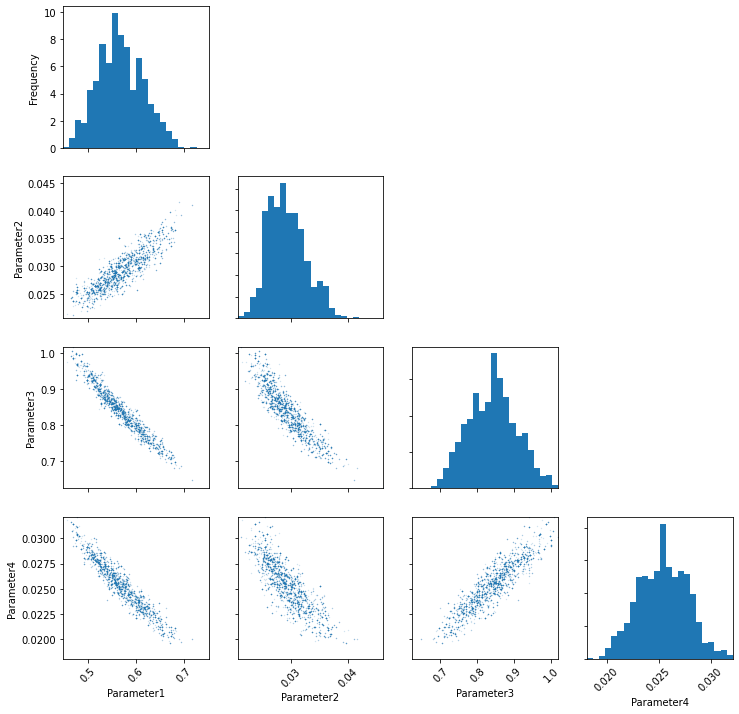

In [137]:
import pints.plot

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains[:, 1000:]), kde=False)

# Show graphs
plt.show()

## 11.
Why is there positive correlation between the estimates of $\alpha$ and $\beta$?

Examining the equation:

$\frac{d u}{dt} = \alpha u - \beta u v$,

we see that if $\alpha\uparrow$ then $\frac{d u}{dt}\uparrow$. So, if $\beta\uparrow$ too, then $\frac{d u}{dt}$ can remain approximately constant, and the dynamics of the system would remain unchanged. In other words, the same observed data sample can be obtained in more than one way.

## 12.
Using a randomly drawn subset of 100 posterior draws, generate posterior predictive draws of the mean predator and prey numbers of time. Then plot these, overlaying the data. Why do the posterior predictive simulations not encompass all the variation seen in the data?

In [138]:
chains_long = np.vstack(chains[:, 1000:])
nsamples = 100
idx = np.random.randint(len(chains_long), size=nsamples)
chains_long = chains_long[idx, ]
times = np.linspace(0, 25, 1001)


for i in range(nsamples):
    temp = lotka_volterra_solve(times,
                                chains_long[i, 0], chains_long[i, 1],
                                chains_long[i, 2], chains_long[i, 3],
                                33, 6)
    temp['replicate'] = str(i)
    if i == 0:
        big_df = temp
    else:
        big_df = big_df.append(temp)

Combine datasets.

In [139]:
df['type'] = 'observations'
big_df['type'] = 'simulations'
big_df1 = pd.concat([df, big_df])

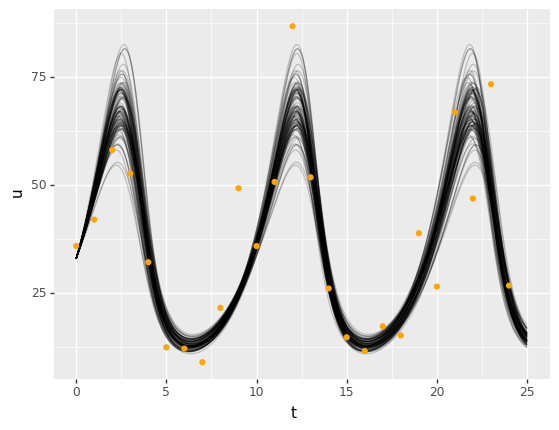

<ggplot: (349019977)>

In [140]:
(ggplot(big_df1.query('type=="simulations"'), aes(x='t', y='u')) +
 geom_line(aes(group='replicate'), alpha=0.2) +
 geom_point(big_df1.query('type=="observations"'), 
            aes(y='u_tilde'), colour='orange'))

## 13.
We are now going to initialise the chains randomly, which is better practice since it is less likely the chains will be biased to a particular area of parameter space. To do this, we are going to create a `UniformLogPrior` object in PINTS, then use the `sample()` method to generate independent draws for each parameter across each chain. To do this, we are going to use the following code:

`log_prior = pints.UniformLogPrior([0, 0, 0, 0], [2, 0.1, 2.0, 0.2])`

Using this `log_prior` object, sample initial positions for the chains and re-run the MCMC sampling as above. Afterwards, plot the path of the chains over time and compute convergence measures. Do the chains look as close to convergence as before?

In [142]:
log_prior = pints.UniformLogPrior([0, 0, 0, 0],
                                  [2, 0.1, 2.0, 0.2])
xs = log_prior.sample(nchains)
mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(200)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


1     8      0.5       0.5       0         0.5        0:00.2
2     12     0.667     0.667     0.333     0.667      0:00.4
3     16     0.75      0.75      0.25      0.5        0:00.5
20    84     0.238     0.524     0.238     0.238      0:02.4
40    164    0.171     0.293     0.122     0.195122   0:04.7
60    244    0.115     0.246     0.0984    0.147541   0:07.0
80    324    0.0864    0.21      0.0741    0.123      0:09.2
100   404    0.0693    0.168     0.0594    0.109      0:11.6
120   484    0.0579    0.14      0.0496    0.0992     0:14.0
140   564    0.0567    0.121     0.0426    0.0922     0:16.4
160   644    0.0497    0.106     0.0435    0.0807     0:18.7
180   724    0.0552    0.0939    0.0387    0.0718     0:21.0
Initial phase completed.
200   804    0.0498    0.0896    0.0348    0.0746     0:23.3
220   884    0.0679    0.0814    0.0452    0.0905     0:25.6
240   964    0.0954    0.0747    0.104     0.129      0:27.8
260   1044   0.126     0.069     0.126     0.157      0:30.0

In [145]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.85    0.56    0.27    0.51   0.58   1.08   1.79     7.20    149.95  0.67
param 2  0.01    0.03    -0.03   0.00   0.03   0.03   0.06     3.86    59.22   0.27
param 3  1.22    0.49    0.58    0.83   0.94   1.91   2.00     2.81    45.51   0.20
param 4  0.04    0.02    0.02    0.03   0.03   0.06   0.07     2.38    59.09   0.27


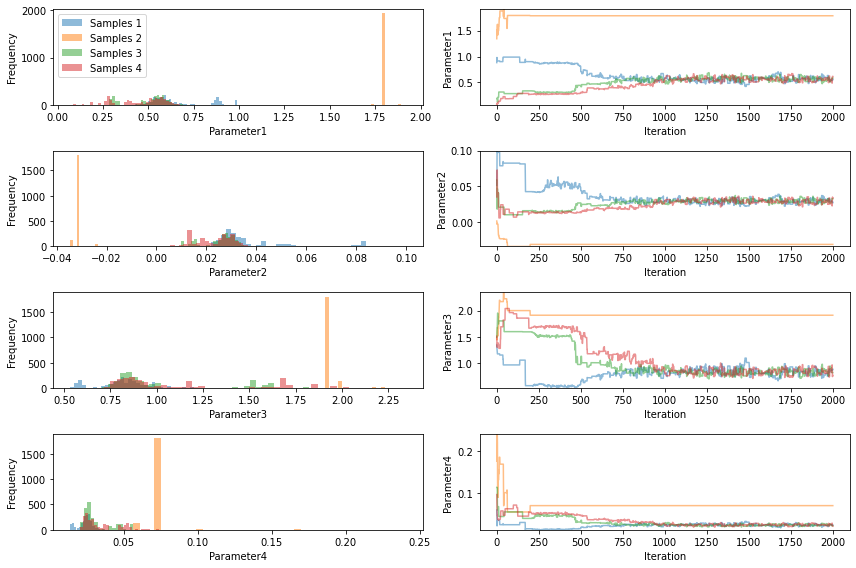

In [146]:
import pints.plot

pints.plot.trace(chains)
plt.show()